# Connect Three 

The primary description of this coursework is available on the CM20252 Moodle page. This is the Jupyter notebook you must complete and submit to receive marks. This notebook adds additional detail to the coursework specification but does not repeat the information that has already been provided there. 

You must follow all instructions given in this notebook precisely.

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing. Remember to save your work regularly.

__You will develop players for Connect-Three on a grid that is 5 columns wide and 3 rows high. An example is shown below showing a win for Player Red.__

<img src="images/connect3.png" style="width: 200px;"/>

## Preliminaries

For your reference, below is a visual depiction of the agent-environment interface in reinforcment learning. The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$. 

<img src="images/agent-environment.png" style="width: 500px;"/>

<br><br><br>

Below, we provide some code that will be useful for implementing parts of this interface. You are not obligated to use this code; please feel free to develop your own code from scratch. 

### Code details

We provide a `Connect` class that you can use to simulate Connect-Three games. The following cells in this section will walk you through the basic usage of this class by playing a couple of games.

We import the `connect` module and create a Connect-Three environmnet called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the `Connect` object will regularly print the progress of the game. This is useful for getting to know the provided code, debugging your code, or if you just want to play around. You will want to set `verbose=False` when you run hundreds of episodes to complete the marked exercises.

This `Connect` environment uses the strings `'o'` and `'x'` instead of different disk colors in order to distuingish between the two players.

Before we start a game, we should call the `reset()` method. This method cleans the board and resets other state variables. The `first_player` argument can be specified (`'o'` or `'x'`) to deterministically choose the starting player. It defaults to `"random"`, in which case each player starts the game with probability of $\frac{1}{2}$.

In [7]:
import connect
env = connect.Connect(verbose=True)
env.reset(first_player='o')

Game has been reset.
[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']]


We can interact with the environment using the `act()` method. This method takes an `action` as input and computes the response of the environment. An action is defined as the column index that a disk is dropped into.

In [8]:
env.act(action=2)

[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']]


The `act()` method inserts a disk into the specified column. 

If we want to change the player on move, we can do so by using the `change_turn()` method. We can check whose turn it is by accessing the `.player_at_turn` attribute.

In [9]:
print("Current player at turn:", env.player_at_turn)
env.change_turn()
print("Current player at turn:", env.player_at_turn)

# Drop another disk into the same centre column.
env.act(action=2)

Current player at turn: o
Current player at turn: x
[[' ' ' ' ' ' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']]


Because we set `verbose=True`, the grid is printed each time we call the `act()` method. This grid is stored as a two-dimensional numpy array in the connect class and you can easily access by calling...

In [10]:
current_grid = env.grid
print(current_grid)
# Notice that the grid now appears to be "upside down" because numpy arrays are printed from "top to bottom".

[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ']]


In [11]:
# Let's make another move.
env.change_turn()
env.act(action=2)

[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' 'o' ' ' ' ']]


If we make another move with `act(action=2)`, the environment will throw an error because that column is already filled.

In [12]:
# This cell should throw an error!
env.change_turn()
env.act(action=2)

IndexError: index 3 is out of bounds for axis 0 with size 3

The attribute `.available_actions` contains a numpy array of all not yet filled columns.

In [13]:
print(env.available_actions)
# Column index '2' is missing because this column is already filled

[0 1 3 4]


The `Connect` class contains a method called `was_winning_move()` that checks whether the last move won the game (returns `True`) or not (returns `False`). 

In [14]:
# Obviously the game has not yet been won by any player.
print("Winning move?", env.was_winning_move()) 

# Make some moves
env.act(action=3)
env.change_turn()
env.act(action=1)
env.change_turn()
env.act(action=3)
env.change_turn()
env.act(action=0)

# Check again whether a player has won the game.
print("Winning move?", env.was_winning_move()) 

Winning move? False
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' ' ' 'o' 'x' ' ']]
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' ' ' ' ']
 [' ' 'o' 'o' 'x' ' ']]
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' 'x' ' ']
 [' ' 'o' 'o' 'x' ' ']]
[[' ' ' ' 'o' ' ' ' ']
 [' ' ' ' 'x' 'x' ' ']
 ['o' 'o' 'o' 'x' ' ']]
Player ' o ' has won the game!
Winning move? True


Finally, the `Connect` class contains a method called `grid_is_full()` that checks whether the grid still contains empty slots. You can use this method to check whether the game is a draw.

Feel free to modify existing or add new methods to the `Connect` class.

## Part 1: Q-learning

Your opponent is always the first player. Your agent is always the second player.

For your reference, the pseudo-code for Q-learning is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 6.5).
<img src="images/q_learning.png" style="width: 600px;"/>

Prepare a **learning curve** following the directions below. We refer to this as Plot 1.

After $n$ steps of interaction with the environment, play $m$ games with the current policy of the agent (without modifying the policy). Think of this as interrupting the agent for a period of time to test how well it has learned so far. Your plot should show the total score obtained in these $m$ games as a function of $n, 2n, 3n, … kn$. The choices of $n$ and $k$ are up to you. They should be reasonable values that demonstrate the efficiency of the learning and how well the agent learns to play the game eventually. Use $m=10$. 

This plot should show the mean performance of $a$ agents, not the performance of a single agent. Because of the stochasticity in the environment, you will obtain two different learning curves from two different agents even though they are using exactly the same algorithm. We suggest setting $a$ to 30 or higher.

Present a single mean learning curve with your choice of parameters $\epsilon$ and $\alpha$. The plot should also show (as a baseline) the mean performance of a random agent that does not learn but chooses actions uniformly randomly from among the legal actions. Label this line “Random Agent”. 

Please include this plot as a static figure in the appropriate cell below. You can look at the source code of this markdown cell to find out how to embed figures using html or you can use drag & drop. If you link to locally stored images, make sure to include those in your submission.

In [270]:
import connect
import random
import numpy as np
import matplotlib.pyplot as plt
env = connect.Connect(verbose=False)
q = {}
alpha= 0.99
gamma = 0.01
gamma_ch = 0.98/games
epsilon = 5
games = 100000
change = 0.98 / (games)

def string_state(state):
    
    """Turns current game grid into a string"""
    
    stringed = ""
    
    for i in range(0,3):
        for j in range(0,5):
            stringed += state[i,j]
            
    return stringed

def get_max(state_actions):
    """Gets the maximum possible action value for part of Q-learning equation"""
    s = string_state(np.copy(env.grid))
    
    # makes entry for this state if one doesn't already exist
    if s not in q:
        #new_state(s,state_actions)
        #print("new get_max state")
        #print(s)
        return 0
    else:
        avs = q[s]

        highest = -10000

        # finds highest possible action value, returns this
        for i in avs:
            if avs[i] > highest:
                highest = avs[i]
                #print("highest=",avs[i])

        return highest
    
def get_greedy():
    state_actions = np.copy(env.available_actions)
    s = string_state(np.copy(env.grid))
    if s not in q: new_state(s,state_actions)
        
    r = random.randint(0,epsilon)
    
    #if r==0: return random.randint(0, len(state_actions)-1)
    
    avs = q[s]
    highest = -10000
    choice = 0

    iteration = 0
    for i in avs:
        print("avs[i]",avs[i])
        if avs[i] > highest:
            highest = avs[i]
            choice = i
            #print("choice now:",choice)
        iteration += 1
        
    return choice
                  
    
def new_state(s, state_actions):
    """Updates q-table with new state when a new state is found"""
    #state_actions = np.copy(env.available_actions)
    
    # l will contain all the possible actions that can be taken from this state
    l = {}
    for i in range(0, len(state_actions)):
        j = str(state_actions[i])
        l[j] = 0.0
    q[s] = l

def update_q(state,last_action,reward,state_actions):
    """Updates value in the q table using the given Q-learning equation"""
    
    global alpha    
    global gamma
    
    # stringifies the state
    s = string_state(state)
    
    # makes entry for this state if one doesn't already exist
    if s not in q: new_state(s,state_actions)
        
    # gets list of possible actions for the given state
    avs = q[s]
    # gets the max a part of the equation
    max_a = get_max(state_actions)
    
    # updates value in q-table
    a = str(last_action)
    
    if a not in avs: print("huh")
        
    avs[a] += float(alpha * (reward + gamma * max_a - avs[a]))

def perform_random_move():
    """Performs a random move for whatever player called it"""
    av = env.available_actions
    action = random.randint(0, len(av) - 1)
    env.act(av[action])
    
def get_best(state):
    s = string_state(state)
    
    # makes entry for this state if one doesn't already exist
    if s not in q: 
        new_state(s,np.copy(env.available_actions))
        #print("made state")
    
    avs = q[s]

    highest = -10000
    
    choice = 0

    #print("avs:", avs)
    #print("env.aa:", env.available_actions)
    #print(s)
    
    # finds highest possible action value, returns this
    for i in avs:
        #print("i:",i)
        if i in avs:
            #print("avs[",i,"] =",avs[str(i)])
            if avs[i] > highest:
                highest = avs[i]
                choice = i
                #print("choice now:",choice)
            
    #print("choice:", choice)

    return choice
            
    
def player_turn(testing):
    """Code to dictate the turn for the player"""
    env.change_turn()
    
    state = np.copy(env.grid)
    
    #gets available actions
    av = np.copy(env.available_actions)
    
    if not testing:
        # not testing, so chooses random action
        action = random.randint(0, len(av) - 1)
        env.act(av[action])
        return av[action]
    else:
        #action = random.randint(0, len(av) - 1)
        action = int(get_best(state))
        #print("action:",action)
        env.act(action)
        return action
    
def opponent_turn():
    env.change_turn()
    perform_random_move()

def play_turn_and_done(testing):
    # check if grid is full before performing player term
    
    reward = 0
    
    if env.grid_is_full(): return 0
    
    state = np.copy(env.grid)
    state_actions = np.copy(env.available_actions)
    last_action = player_turn(testing)
    
    # if player did winning turn then return 1 (for win)
    if(env.was_winning_move()):
        reward = 1
    else:
        opponent_turn()
    
        # if opponent bot won then return -1 (for loss)
        if(env.was_winning_move()):
            reward = -1
            
    if not testing: update_q(state,last_action,reward,state_actions)
    
    if reward == 1 or reward == -1:
        return reward
    
    return -2
    

def play_game(testing):
    env.reset(first_player='o')
    done = False
    perform_random_move()
    while True:
        ret = play_turn_and_done(testing)
        if ret == 1 or ret == 0 or ret == -1:
            return ret
        
def play_rand():
    env.reset(first_player='o')
    done = False
    while True:
        if env.grid_is_full(): return 0 
        opponent_turn()
        if env.was_winning_move():
            return -1
        else:
            env.change_turn()
            if env.grid_is_full(): return 0
            perform_random_move()
            if env.was_winning_move():
                return 1
            
def reset():
    q = {}
    print(q)
        
def test(random):
    agents = 30
    m = 10
    
    acc = 0
    for i in range(0,agents):
        for j in range(0,m):
            r = 0
            if random:
                r = play_rand()
            else:
                r = play_game(testing=True)
            
            acc += r
            #if r == 1: acc += 1

    return (acc/(agents))

def game():
    print("Playing game...")
    
    global alpha
    global gamma
    
    alpha = 0.7
    gamma = 0.05
    
    games = 100000
    n = 1000
    k = int(games/n)
    
    ep_inc = int(95 / k)
    gamma_inc = 0.98/k
    
    results = np.empty(k)
    rand_results = np.empty(k)
    
    for i in range(0,k):
        for j in range(0,n):
            play_game(testing=False)
        results[i] = test(random=False)
        rand_results[i] = test(random=True)
        global epsilon
        epsilon += ep_inc
        #gamma += gamma_inc
        #print(gamma)
        print(i)
    
    #q = {}
    
    plt.plot(results)
    plt.plot(rand_results)
    plt.title("30 agents, n=1000, m=10, games = 100000")
    plt.xlabel("Games played (in thousands)")
    plt.ylabel("Total score by m agents")
    #plt.ylim[-10,10]
    
    #plt.axis([0,k,-10,10]) # Put in side your range [xmin,xmax,ymin,ymax], like ax.axis([-5,5,-5,200])


Playing game...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


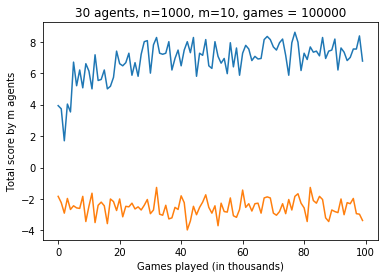

In [271]:
game()

(A) [continued} Insert your static learning curve here (Plot 1).

<img src="plot_best.png" style="width: 600px;"/>

(B) In 3 sentences or less, explain your conclusions from the plot above. How close does your (average) agent get to the best possible level of performance? How efficiently does your (average) agent learn? 

YOUR ANSWER HERE 

(C) In five sentences or less, explain the key aspects of your implementation. How many state-action pairs do you represent in your Q-table? Describe and justify your settings of $\alpha$ and $\epsilon$. Are there any things you tried out that are not in your final implementation?

YOUR ANSWER HERE

(D) In the cell below, make it possible for us to produce from scratch a learning curve similar to Plot 1 but for a single agent, for a $k$ value of your own choosing. You do not need to include the baseline for random play.  This code should run in less than 30 seconds (ours runs in 2 seconds). 


In [91]:
### This cell should produce from scratch a plot showing a learning curve for a single agent.


## Part 2A
 
Using the minimax policy you computed, answer the following question: The first player (Player 1) drops his/her first disk into column 2 (counting from the left). Consider the resulting state, shown in the following code cell. 

In [ ]:
env = connect.Connect(verbose=False)
env.reset(first_player='o')
env.act(action=1)
print(env.grid[::-1])

What is the Minimax Value of this state for Player 2? That is, assuming an optimal opponent, does the Minimax Policy expect to win the game (value = 1), lose the game (value = –1), or end the game in a draw (value = 0)? Please state your answer as a number.    

* The code cell below should compute this value and assign it to a variable called `state_value`.
* Count the number of branches of the game tree that were examined and assign this number to a variable called `num_branches`.

In [ ]:
### Write all your code for Part 2A in or above this cell.

# state_value = ...
# num_branches = ...


In [ ]:
# This is an autograded test cell. Do not delete or change, otherwise you will get 
# no marks for this part of the assignment. Please make sure that this cell has 
# access to the variables state_value and num_branches.

## Part 2B
Plot a learning curve similar to the one in Part 1, comparing your Q-learning algorithm, random play, and Minimax play. Assume as before that the opponent always plays first and uses a random policy.

In [ ]:
### Write all your code for Exercise 2 (B) in or above this cell.


Explain your findings in 3 or fewer sentences. Which policy is better? Why?

YOUR ANSWER HERE.



## Part 3

Using your algorithm, compute the value of the game for your player (recall: your player goes second against a random opponent). The code cell below should compute this value and assign it to a variable called `optimal_policy_value`.

In [ ]:
### Write all your code for Part 3 in or above this cell.

# optimal_policy_value = ...


In [ ]:
# This is an autograded test cell. Do not delete or change, otherwise you will get 
# no marks for this part of the assignment. Please make sure that this cell has 
# access to the variable optimal_policy_value.